[//]: # "Para temas claros usar logo_utn.svg"
<img src="./logo_utn_dark.png" align="right" width="250" /> 

# Análisis de la sensibilidad en la topología Sallen-Key

#### Por Mariano Llamedo Soria

## Resumen

En este documento se analizará un filtro pasabajos Sallen-Key, obteniendo su función transferencia y analizando sus parámetros críticos mediantes el estudio de la sensibilidad. Luego se profundiza este análisis mediante una simulacion numérica y circuital de tipo Montecarlo, para finalmente extraer algunas conclusiones.


<a id='indice'></a>


## Índice

El siguiente índice permitirá navegar por las secciones del documento con mayor facilidad.


0. [Introducción](#0.a)


1. Simulación simbólica:

    a. [Análisis teórico de la función transferencia](#1.a).

    b. [Asumiendo realimentación negativa (RN) con opamp ideal](#1.b).
    
    c. [Sin asumir RN con opamp ideal](#1.c).
    
    d. [Sin asumir RN y con opamp NO ideal](#1.d).
    
    e. [Análisis de sensibilidad](#1.e).
    
2. Simulación numérica.
    
    a. [Simulación numérica: Análisis Montecarlo](#2.a).
    
    b. [Resultados cualitativos (gráficas)](#2.b).

    c. [Resultados cuantitativos (tablas)](#2.c).

    d. [Conclusiones](#2.d).

3. Simulación circuital.

    a. [Circuito analizado](#3.a).

    b. [Resultados cualitativos (gráficas)](#3.b).

    c. [Análisis de las mediciones automáticas](#3.c).

    d. [Resultados cuantitativos](#3.d).

    e. [Conclusiones de la simulación circuital](#3.e).

4. [Conclusiones generales](#4.0).



<a id='0.a'></a>

### I) Introducción


En el siguiente documento se analizará la dispersión de parámetros:

 * Factor de selectividad ($Q$)
 * Frecuencia de corte o resonancia ($\omega_0$)
 * y la ganancia ($K$)

correspondiente a una topología Sallen-Key en su configuración pasabajo, mediante la siguiente red:


<img src="./sallenkey.png" align="center" width="700" style="border:10px solid white" /> 

Este circuito implementa la siguiente transferencia de tensión:

$$ T(s) =\frac{V_o}{V_i} = \frac{ K·\omega_0^2}{s^2 + s · \omega_0/Q + \omega_0^2} $$

En las siguientes secciones se describirá la relación entre los parámetros y los elementos circuitales.

Esta topología fue propuesta originalmente en 1955 por R. P. Sallen and E. L. Key del [laboratorio Lincoln](https://en.wikipedia.org/wiki/MIT_Lincoln_Laboratory), en el MIT [[wiki]](https://en.wikipedia.org/wiki/Sallen%E2%80%93Key_topology). Es uno de los primeros filtros activos publicados, y posiblemente uno de los más populares. Una de sus principales ventajas al momento de su publicación fue la posibilidad de diseñar filtros de orden superior de forma modular. Es decir que cada etapa podía diseñarse por separado debido al uso de seguidores de tensión, o lo que se consideró años después, la topología de filtos *fuente de tensión controlada por tensión* (VCVS por sus siglas en inglés). Otra ventaja importante es que necesita un solo dispositivo activo, en nuestro caso un *opamp*, aunque la publicación original se propuso un amplificador valvular en configuración de cátodo común. La idea original fue que el dispositivo activo funcione aproximadamente como un *buffer*, proveyendo separación de las secciones adyacentes (casi) sin atenuación de la señal. En el caso de la configuración actual, el *opamp* también permite obtener ganancia, como veremos más adelante. Ciertamente esta topología tiene varias desventajas, posiblemente la más notoria es su dificultad de implementar factores de selectividad (Q) elevados, como se analizará en este documento.

<a id='indice'></a>




<a id='1.a'></a>

### 1.a) Análisis teórico de la función transferencia


Se comienza analizando las ecuaciones que gobiernan el comportamiento de la red propuesta:


 1. Nodo $V_b$
 
  $ V_b . (G_1 + G_2 + s.C) - V_i . G_1 - V_a . G_2  - V_o . s.C = 0$


 2. Nodo $V_a$ ó $V_+$
 
  $ -V_b . G_2 + V_a . (G_2 + s.C) = 0$


 3. Nodo $V_-$
 
  $ V_- . (G_a + G_b) - V_o . G_b = 0$


Si consideramos que la red está **realimentada negativamente**, podemos agregar la siguiente ecuación:


 4. $V_- = V_+ = V_a$
 
  
y proceder a resolver el sistema de ecuaciones para $\frac{V_o}{V_i}$, lo cual concluiría el análisis de la transferencia del filtro. 

Sin embargo, a modo de ejemplo, demostraremos las posibilidades de sympy para el manejo de expresiones algebraicas analizando la red como si no supiéramos de qué clase de realimentación se trata. Para tal fin debemos contemplar la siguiente ecuación que describe el funcionamiento del *opamp*.


 4. (bis) $ (V_+ - V_-). A(s) = (V_a - V_-). A(s) = V_o$
 
Luego si asumimos $A(s) \to \infty$ para una salida $V_o$ finita, entonces 4 (bis) se convierte en la ecuación 4. Finalmente, el comportamiento del *opamp* también puede hacerse tan complejo como se desee, por caso usando el modelo de integrador


 5. $ A(s) = \frac{\omega_t}{s}$


Dependiendo la complejidad del análisis podemos optar por cualquiera de los tres caminos sugeridos más arriba. A modo de ejemplo, resolveremos los tres para presentar las posibilidades de sympy.


[Volver al índice](#indice)

In [1]:
# Inicialización e importación de módulos

# Módulos para Jupyter
import warnings
warnings.filterwarnings('ignore')

# Módulos externos
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import TransferFunction

fig_sz_x = 8
fig_sz_y = 6
fig_dpi = 150 # dpi

mpl.rcParams['figure.figsize'] = (fig_sz_x, fig_sz_y)
mpl.rcParams['figure.dpi'] = fig_dpi

plt.figure(1)
plt.plot(np.random.rand(10))
plt.close(1)

# módulo de análisis simbólico
import sympy as sp
# variable de Laplace
from sympy.abc import s
from IPython.display import display, Math, Markdown

# Ahora importamos las funciones de PyTC2
from pytc2.sistemas_lineales import simplify_n_monic, parametrize_sos
from pytc2.general import print_subtitle


<a id='1.b'></a>

### 1.b) Alternativa 1: Red negativamente realimentada 

Procedemos a ingresar las ecuaciones 1-4.

[Volver al índice](#indice)

In [2]:

# variables simbólicas
s = sp.symbols('s', complex=True)
Va, Vb, Vi, Vo = sp.symbols("Va, Vb, Vi, Vo")
G1, G2, Ga, Gb, C, As, wt = sp.symbols("G1, G2, Ga, Gb, C, As, wt")

# Sistemas de ecuaciones del modelo ideal, negativamente realimentado
aa = sp.solve([ 
                Vb*(G1 + G2 + s*C) - Vi * G1 - Va * G2 - Vo * s*C, 
                -Vb*G2 + Va * (G2 + s*C),
                -Vo*Gb + Va * (Ga + Gb)
                ], 
                [Vo, Vi, Va, Vb])
T1 = aa[Vo]/aa[Vi]

num, den = sp.fraction(sp.simplify(sp.expand(T1)))
num = sp.Poly(num,s)
den = sp.Poly(den,s)
num1, den1, w_on, Q_n, w_od, Q_d, k1 = parametrize_sos(num, den)

print_subtitle('Transferencia obtenida')

display(Math( r' \frac{V_o}{V_i} = ' + sp.latex(sp.Mul(k1,num1/den1, evaluate=False)) ))

print_subtitle('Parámetros')

display(Math( r' k = ' + sp.latex(k1) ))

display(Math( r' \omega_0 = ' + sp.latex(w_od) ))

display(Math( r' Q = ' + sp.latex(Q_d) ))


#### Transferencia obtenida

<IPython.core.display.Math object>

#### Parámetros

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<a id='1.c'></a>

### 1.c) Alternativa 2: Sin asumir realimentación negativa (RN) 

Procedemos a ingresar las ecuaciones 1-3 y 4bis.

[Volver al índice](#indice)

In [3]:

# pata inversora del opamp
Vinv  = sp.symbols("Vinv")

# Sistemas de ecuaciones del modelo ideal, negativamente realimentado
aa = sp.solve([ 
                Vb*(G1 + G2 + s*C) - Vi * G1 - Va * G2 - Vo * s*C, 
                -Vb*G2 + Va * (G2 + s*C),
                -Vo*Gb + Vinv * (Ga + Gb),
                (Va - Vinv) * As - Vo
                ], 
                [Vo, Vi, Vinv, Va, Vb])
T2 = aa[Vo]/aa[Vi]

# modelo ideal sin asumir realimentación negativa
T2 = sp.limit(T2, As, sp.oo)

num, den = sp.fraction(sp.simplify(sp.expand(T2)))
num = sp.Poly(num,s)
den = sp.Poly(den,s)
num2, den2, w_on2, Q_n2, w_od2, Q_d2, k2 = parametrize_sos(num, den)

print_subtitle('Transferencia sin asumir RN')

display(Math( r' \frac{V_o}{V_i} = ' + sp.latex(sp.Mul(k2,num2/den2, evaluate=False)) ))

print_subtitle('Parámetros')

display(Math( r' k = ' + sp.latex(k2) ))

display(Math( r' \omega_0 = ' + sp.latex(w_od2) ))

display(Math( r' Q = ' + sp.latex(Q_d2) ))


#### Transferencia sin asumir RN

<IPython.core.display.Math object>

#### Parámetros

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<a id='1.d'></a>

Afortunadamente los resultados convergen, sin embargo, esto no siempre podría ser así. A modo de ejemplo se finaliza la demostración de las posibilidades de sympy extendiendo el análisis de la red considerando al opamp mediante su modelo de integrador.

### 1.d) Alternativa 3: Sin asumir RN y *opamp* no ideal

Procedemos a ingresar las ecuaciones 1-3, 4bis y 5.

[Volver al índice](#indice)

In [4]:

# Sistemas de ecuaciones del modelo ideal, negativamente realimentado
aa = sp.solve([ 
                Vb*(G1 + G2 + s*C) - Vi * G1 - Va * G2 - Vo * s*C, 
                -Vb*G2 + Va * (G2 + s*C),
                -Vo*Gb + Vinv * (Ga + Gb),
                (Va - Vinv) * As - Vo
                ], 
                [Vo, Vi, Vinv, Va, Vb])

T3 = aa[Vo]/aa[Vi]

# modelo integrador A(s)=\omega_t/s (sin asumir realimentación negativa)
T3 = sp.simplify(sp.expand(T3.subs(As, wt/s)))

T3 = simplify_n_monic(T3)

print_subtitle('Transferencia opamp no ideal')

display(Math( r' \frac{V_o}{V_i} = ' + sp.latex(T3) ))


#### Transferencia opamp no ideal

<IPython.core.display.Math object>

Con esto se termina la demostración de las posibilidades de simulación simbólica de sympy.

Ahora se retoma el análisis de la transferencia para *opamp ideal*, como se analizó en las alternativas 1 y 2. La transferencia de tensión definida genéricamente

$$ T(s) = \frac{ K·\omega_0^2}{s^2 + s · \omega_0/Q + \omega_0^2} $$

siendo los parámetros

$$ \omega_0^2=\frac{G_1 G_2}{C^2} $$

$$ K=1+G_a/G_b $$

$$ Q=\frac{ \sqrt{G_1 G_2}}{G_1 + G_2(2-K)} $$

y para $R_1 = \frac{1}{G1} = R_2 = R_a = R $ llegamos a 

$$ \omega_0=\frac{1}{RC} $$

$$ Q=\frac{ 1}{3-K} $$

$$ K=1+R_b/R $$


<a id='1.e'></a>

### 1.e) Análisis de sensibilidad


Se procederá a analizar qué tan sensible es la topología Sallen-Key para obtener una transferencia prestablecida al adoptar componentes reales con una determinada tolerancia. En el caso del parámetro $\omega_0$, que depende de $R$ y $C$, su tolerancia $ \frac{\Delta \omega_0}{ \omega_0}$

$$ \frac{\Delta \omega_0}{ \omega_0} = S^{\omega_0}_{R} . \frac{\Delta R}{R} + S^{\omega_0}_{C} . \frac{\Delta C}{C} $$

y sabemos que 

$$ S^{\omega_0}_{R} = \frac{R}{\omega_0} . \frac{\partial \omega_0}{\partial R} $$ 

$$ S^{\omega_0}_{R} = R. (RC) . (-1) . \frac{1}{(RC)^2} . C = -1  $$ 

$$ S^{\omega_0}_{C} = C. (RC) . (-1) . \frac{1}{(RC)^2} . R = -1  $$ 

es decir que si $\frac{\Delta R}{R} = \frac{\Delta C}{C} = 5$% , entonces resulta que $\frac{\Delta \omega_0}{ \omega_0} = 10$ %. El signo de la sensibilidad no tiene importancia para este análisis.

Procedemos a calcular el resto de las sensibilidades para cada parámetro

$$ \frac{\Delta K}{ K} = S^{K}_{R} . \frac{\Delta R}{R} + S^{K}_{R_b} . \frac{\Delta R_b}{R_b} $$

$$ S^{K}_{R} = \frac{R}{K} . \frac{\partial K}{\partial R}  = \frac{R^2}{R+R_b} (-1) \frac{R_b}{R^2} = - \frac{R_b}{R+R_b} $$ 

$$ S^{K}_{R_b} = \frac{R_b}{R+R_b} $$ 

En el caso de $K$ se observa que para iguales tolerancias en los valores de los resistores, las sensibilidades se contrarrestan y podría pensarse que se neutralizan. Esto como se verá más adelante no se corrobora ni en el análisis de Montecarlo, y mucho menos en la práctica.

Dejamos para el final el parámetro más crítico de esta topología

$$ \frac{\Delta Q}{ Q} = S^{Q}_{K} . S^{K}_{R} . \frac{\Delta R}{R} + S^{Q}_{K} . S^{K}_{R_b} . \frac{\Delta R_b}{R_b}  = S^{Q}_{K} . \frac{\Delta K}{ K}  $$

$$ S^{Q}_{K} = \frac{K}{Q} . \frac{\partial Q}{\partial K}  = K.(3-K) \frac{-(-1)}{(3-K)^2} = K.Q $$ 

Se advierte claramente que la tolerancia con que se logre fijar la ganancia K, se verá aumentada por la propia ganancia y por el Q prestablecido. Si bien esto podría no ser un problema para Q moderados a bajos, ciertamente limita las aspiraciones que pueda tener esta red.

[Volver al índice](#indice)

<a id='2.a'></a>

### 2.a) Simulación numérica: Análisis de Montecarlo

Realizaremos un análisis *Montecarlo* de la dispersión de $Q$, $\omega_0$ y $K$ para una red normalizada ($\omega_0=1$) con diferentes valores de $Q$. Para ello se muestrarán valores de $C$, $R$ y $R_B$, de distribuciones uniforme, definida por la tolerancia de cada componente (resistores al 5% y capacitores al 10%). Para ello simulamos el comportamiento de la función transferencia para dos valores de $Q = [2, 4, 8]$.

[Volver al índice](#indice)

In [5]:
# Importamos las funciones de PyTC2

from pytc2.sistemas_lineales import pzmap, GroupDelay, bodePlot, pretty_print_bicuad_omegayq


<a id=2.b></a>

#### Transferencia sampleada al azar para Q=2

<IPython.core.display.Math object>

#### Transferencia deseada para Q=2

<IPython.core.display.Math object>

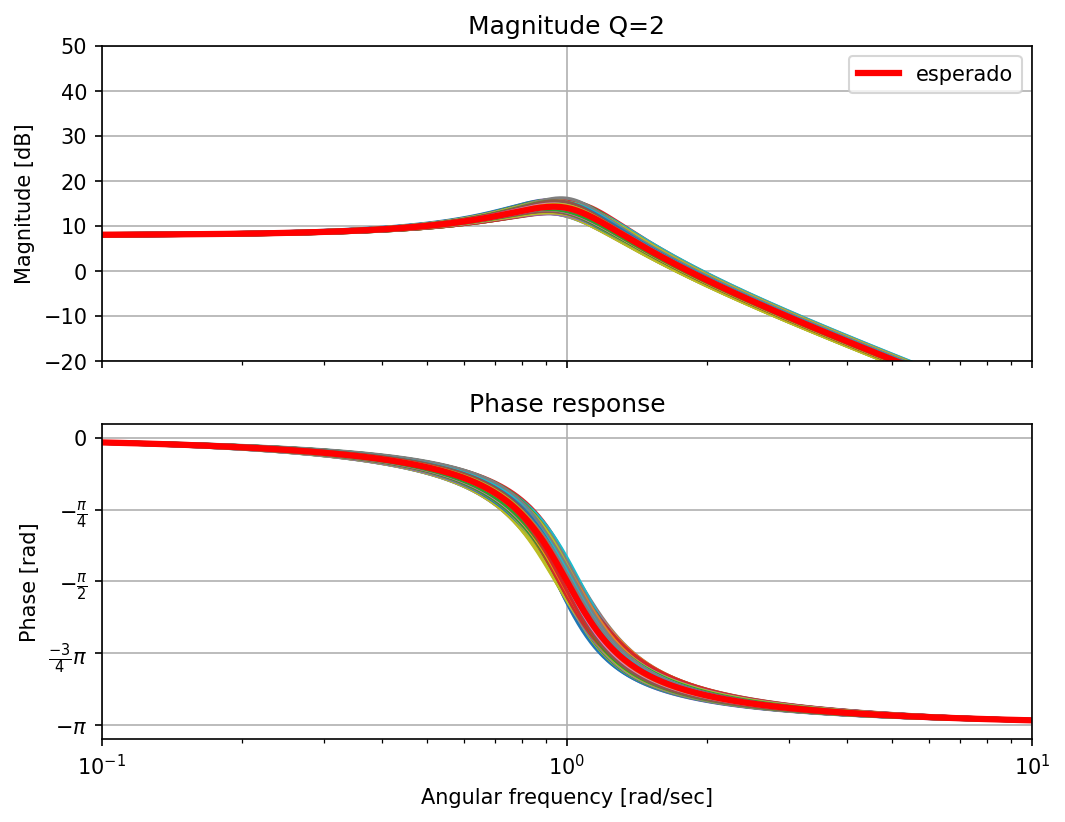

#### Transferencia sampleada al azar para Q=4

<IPython.core.display.Math object>

#### Transferencia deseada para Q=4

<IPython.core.display.Math object>

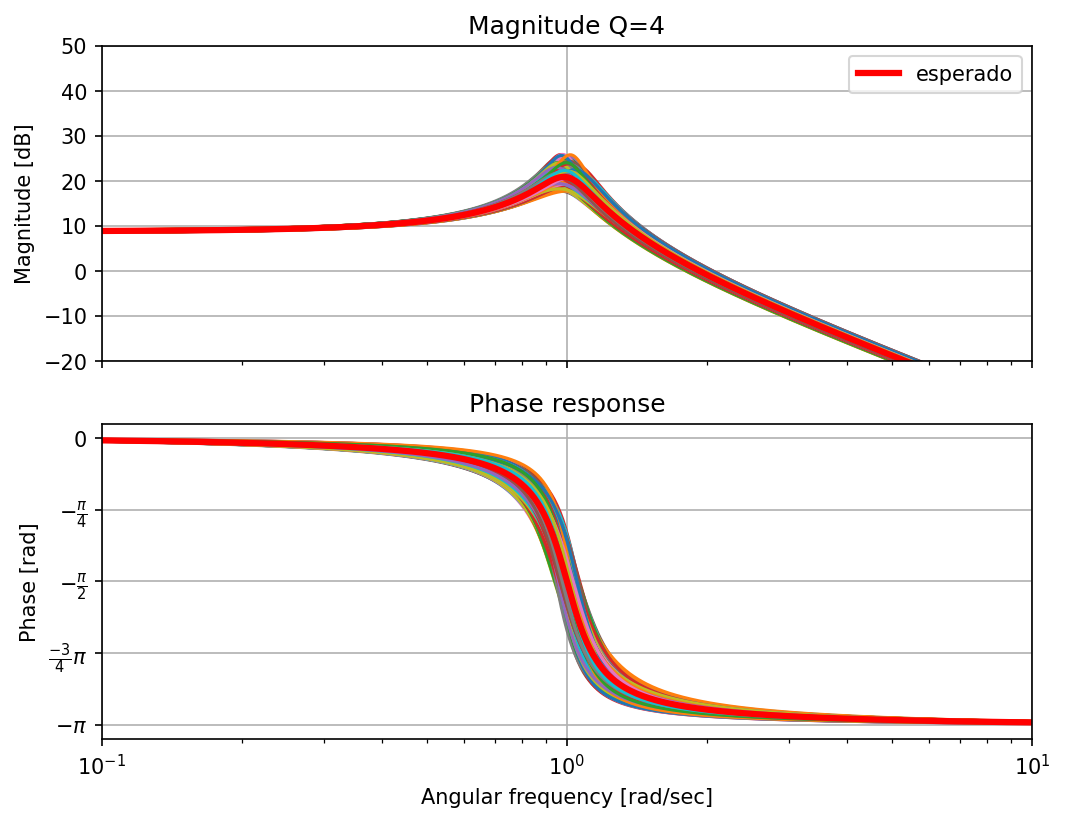

#### Transferencia sampleada al azar para Q=8

<IPython.core.display.Math object>

#### Transferencia deseada para Q=8

<IPython.core.display.Math object>

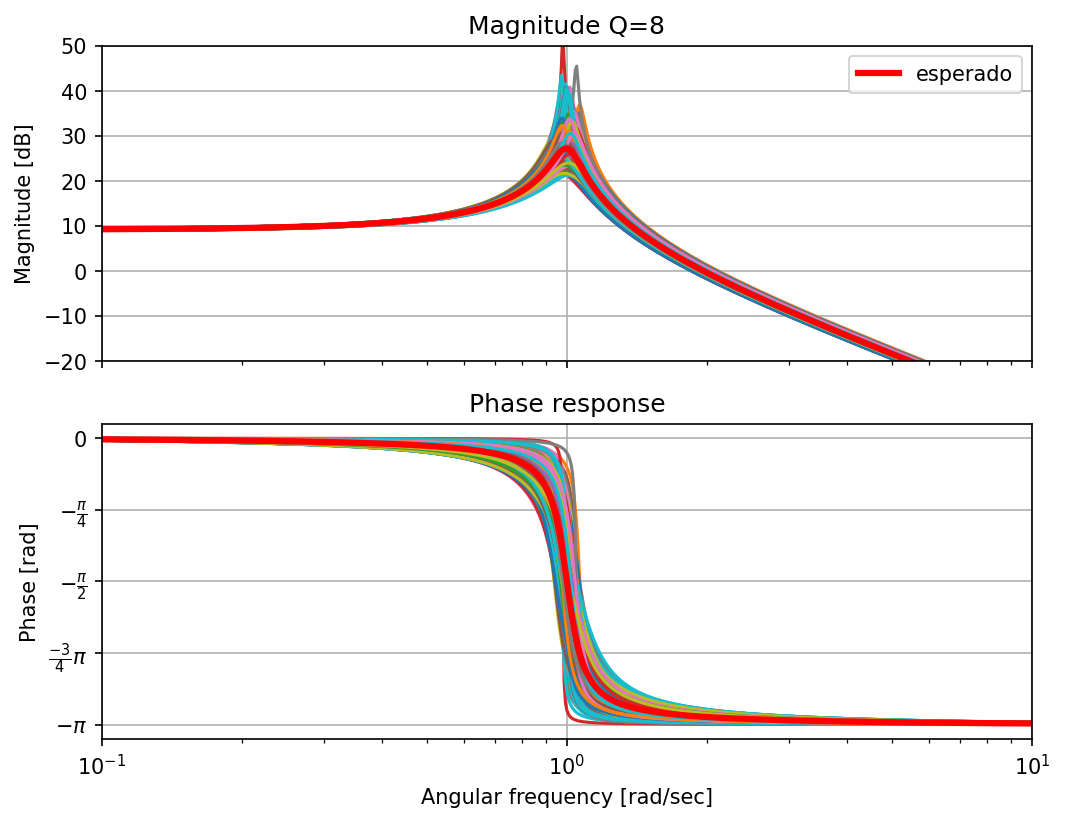

[Volver al índice](#indice)

In [6]:
################
## simulación ##
################

def my_experiment( QQset ):
    # Cantidad de iteraciones o experimentos
    NN = 1000
    # Tolerancia de los componentes
    tol_R = 5
    tol_C = 10

    # Q y \omega_0 proyectados
    QQ = QQset
    W0 = 1

    # Valores de los componentes 
    CC = 1
    RR = 1
    RA = RR
    # si R1 = R2
    #RB = (2-1/QQ)*RA
    # alguna vez se intentó con R1 != R2
    R1 = RR/1
    R2 = 1/(R1*W0**2*CC**2)
    KK = 2-(np.sqrt(1/R1/R2)-QQ/R1)/(QQ/R2)
    RB = RA * KK - RA
    
    # Valores de los componentes para cada iteración:
    # Cada valor es muestreado independientemente de una distribución uniforme,
    # limitada por la tolerancia impuesta.
    
    # Recordar que C es el valor que asumirá tanto C1 como C2, pero al momento de armar
    # el circuito, ambos valores son independientes.
    all_C1 = np.random.uniform(CC * (100-tol_C/2)/100 , CC * (100+tol_C/2)/100, size=NN )
    all_C2 = np.random.uniform(CC * (100-tol_C/2)/100 , CC * (100+tol_C/2)/100, size=NN )
    
    # Recordar que R es el valor que asumirá tanto R1, R2 y Ra, pero al momento de armar
    # el circuito, los valores son independientes.
    all_R1 = np.random.uniform(R1 * (100-tol_R/2)/100 , R1 * (100+tol_R/2)/100, size=NN )
    all_R2 = np.random.uniform(R2 * (100-tol_R/2)/100 , R2 * (100+tol_R/2)/100, size=NN )
    all_RA = np.random.uniform(RA * (100-tol_R/2)/100 , RA * (100+tol_R/2)/100, size=NN )
    all_RB = np.random.uniform(RB * (100-tol_R/2)/100 , RB * (100+tol_R/2)/100, size=NN )

    plt.close('all')

    fig_hdl = plt.figure(figsize=(fig_sz_x, fig_sz_y), dpi= fig_dpi, facecolor='w', edgecolor='k')
    axes_hdl = fig_hdl.subplots(2, 1, sharex='col')
    fig_id = fig_hdl.number

    # analizaremos cada iteración resultante
    #for (this_C, this_R, this_RB) in zip( all_C, all_R, all_RB):
    for ii in range(NN):

        this_KK = 1 + all_RB[ii]/all_RA[ii]
        
        this_QQ = np.sqrt(1/(all_R1[ii]*all_R2[ii]))/( 1/all_R1[ii] + (2-this_KK)/all_R2[ii] )
        this_w0 = 1/np.sqrt(all_R1[ii]*all_R2[ii]*all_C1[ii]*all_C2[ii])

        num = [this_KK * (this_w0**2)]
        den = [1, this_w0/this_QQ, this_w0**2]

        my_tf = TransferFunction( num, den )

        _, axes_hdl = bodePlot(my_tf, fig_id)


    # visualizamos la última realización a modo de ejemplo
    print_subtitle('Transferencia sampleada al azar para Q={:d}'.format(QQset))

    pretty_print_bicuad_omegayq(num,den)

    # finalmente ploteamos también la transferencia con los valores esperados
    # sin incertidumbre alguna sobre sus valores.
    KK = 1 + RB/RA

    # si R1 = R2
    #QQ = 1/(3-KK)
    # si R1/2 = R2
    #QQ = np.sqrt(2)/(4-KK)
    QQ = np.sqrt(1/R1/R2)/(1/R1+1/R2*(2-KK))
    WW0 = 1/np.sqrt(R1*R2*CC*CC)

    num = [KK * (WW0**2)]
    den = [1, WW0/QQ, WW0**2]

    # visualizamos la transferencia esperada o media
    print_subtitle('Transferencia deseada para Q={:d}'.format(QQset))

    pretty_print_bicuad_omegayq(num,den)

    my_tf = TransferFunction( num, den )

    w, mag, phase = my_tf.bode(n=300)

    (mag_ax_hdl, phase_ax_hdl) = axes_hdl

    plt.sca(mag_ax_hdl)
    plt.semilogx(w, mag, '-r', label = 'esperado', linewidth=3 )    # Bode magnitude plot

    plt.title('Magnitude Q={:d}'.format(QQset))
    plt.legend()
    plt.ylim([-20, 50])

    plt.sca(phase_ax_hdl)
    plt.semilogx(w, phase*np.pi/180, '-r', linewidth=3)    # Bode phase plot
    plt.xlim([.1, 10])
    plt.show()
    
    return( all_C1, all_C2, all_R1, all_R2, all_RA, all_RB )

# enlace para presentar los resultados.
display(Markdown(r'<a id=''2.b''></a>'))

all_Qset = [2, 4, 8]

all_C1, all_C2, all_R1, all_R2, all_RA, all_RB = my_experiment( QQset = all_Qset[0] )

results = np.vstack([all_C1, all_C2, all_R1, all_R2, all_RA, all_RB]).transpose()
list_results = [results]

for ii in range(1, len(all_Qset)):
    all_C1, all_C2, all_R1, all_R2, all_RA, all_RB = my_experiment( QQset = all_Qset[ii] )
    results = np.vstack([all_C1, all_C2, all_R1, all_R2, all_RA, all_RB]).transpose()
    list_results += [results]
    
results = np.stack( list_results, axis=2 )

# enlace para volver al índice principal.
display(Markdown(r'[Volver al índice](#indice)'))



Para luego analizar estadísticamente la distribución de cada parámetro.

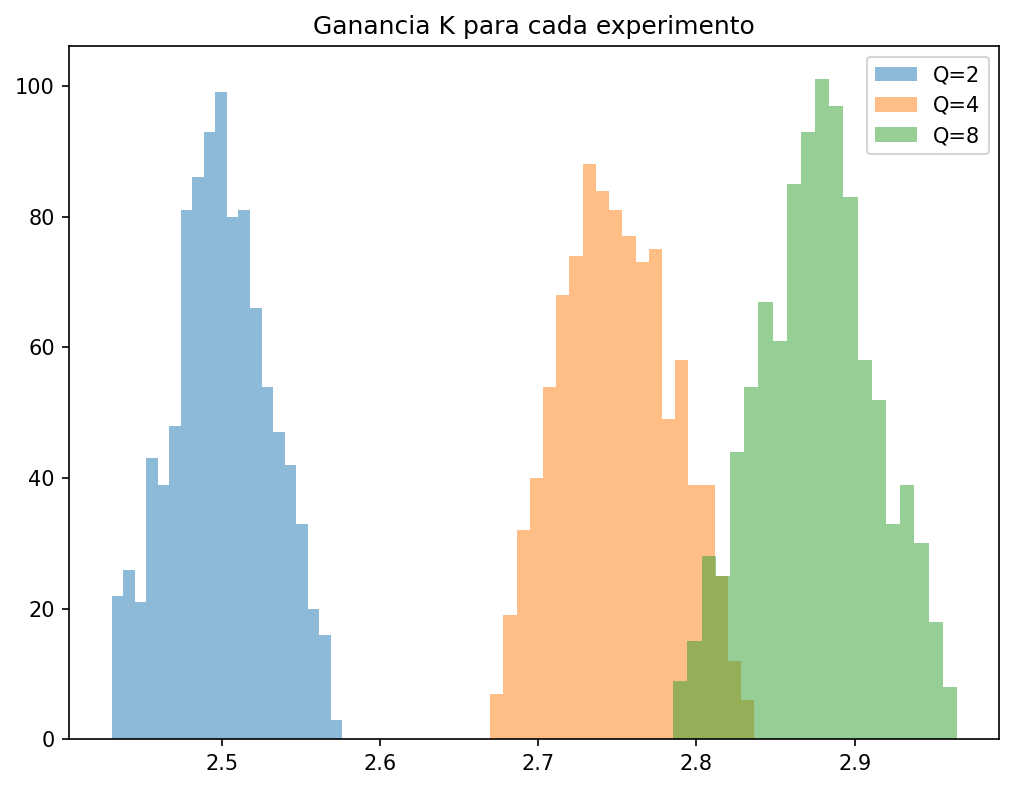

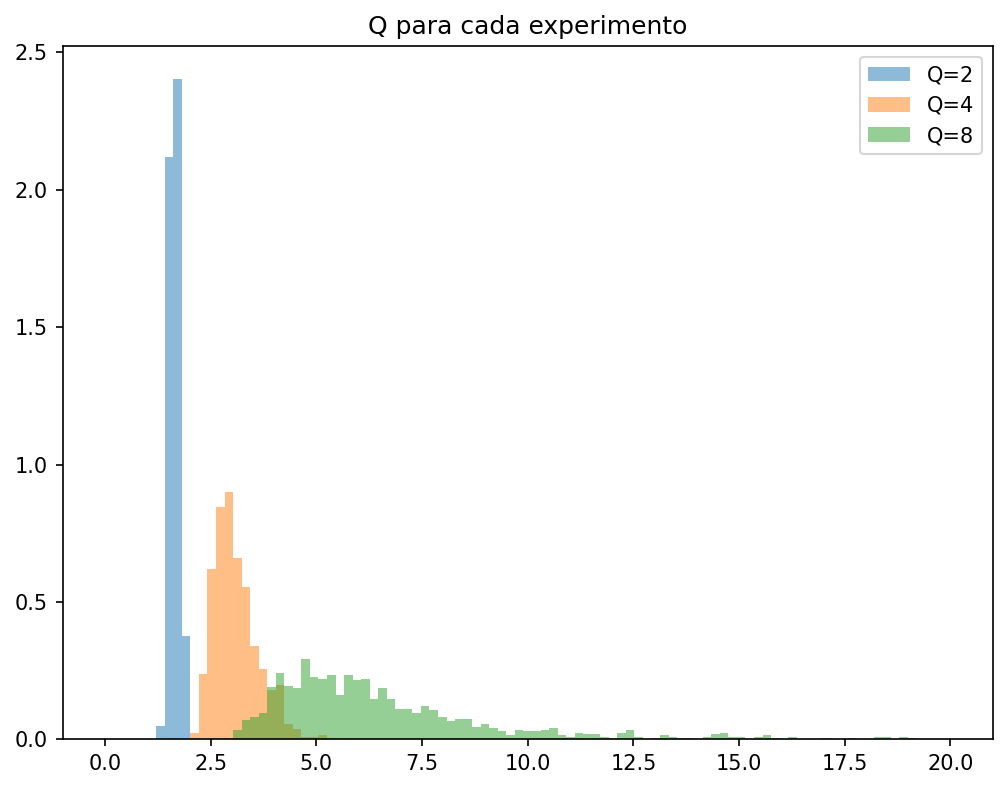

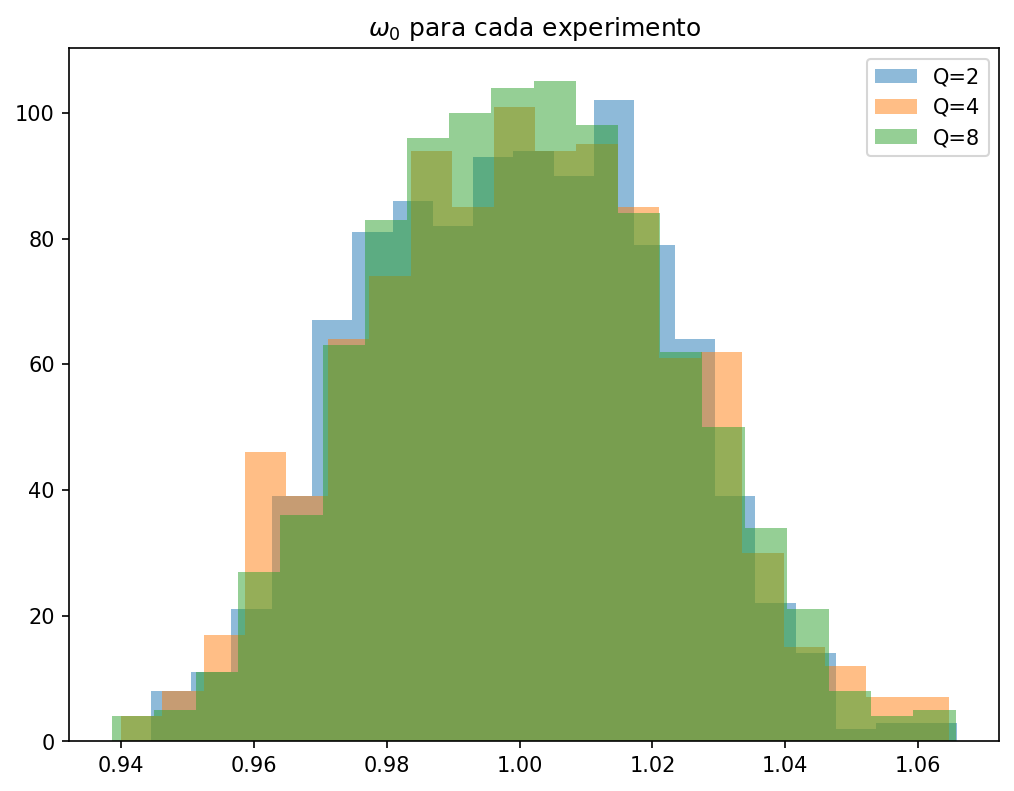

In [7]:
# Ahora vamos a hacer un estudio estadístico de los parámetros Q y \omega_0
# calculo los valores de los parámetros para TODAS las iteraciones
all_KK = 1 + results[:,5,:]/results[:,4,:]
all_QQ = np.sqrt(1/(results[:,5,:]*results[:,4,:]))/( 1/results[:,2,:] + (2-all_KK)/results[:,3,:] )
all_w0 = 1/np.sqrt(results[:,0,:]*results[:,1,:]*results[:,2,:]*results[:,3,:])

plt.figure()
#plt.hist( 20*np.log10(all_KK), 20 )

for ii in range(len(all_Qset)):
    plt.hist( all_KK[:,ii], 20, alpha=0.5, label='Q={:d}'.format(all_Qset[ii]) )
plt.title('Ganancia K para cada experimento')
plt.legend()

#plt.figure(figsize=(fig_sz_x*6/10, fig_sz_y*4/10), dpi= fig_dpi, facecolor='w', edgecolor='k')
plt.figure()
for ii in range(len(all_Qset)):
    plt.hist( all_QQ[:,ii], np.linspace(0,20,100), alpha=0.5, density=True, label='Q={:d}'.format(all_Qset[ii]) )

#plt.xlim([0,20])
plt.title('Q para cada experimento')
plt.legend()

plt.figure()
for ii in range(len(all_Qset)):
    plt.hist( all_w0[:,ii], 20, alpha=0.5, label='Q={:d}'.format(all_Qset[ii]) )

plt.title('$\omega_0$ para cada experimento')
plt.legend()



Como se puede ver en los histogramas, la dispersión o varianza de los parámetros $\omega_0$ y $K$ no se ve alterada por el valor de $Q$ a implementar. Por otro lado, el parámetro $Q$ es el más afectado o sensible a la tolerancia de los componentes en la topología Sallen-Key. El $Q$ depende de la ganancia $K$, que a su vez depende de la relación de dos resistores ($R_a$ y $R_b$). Esta alta sensibilidad puede mitigarse, o bien utilizando resistores con tolerancias bajas (<= 1%), o limitando que el $Q$ a implementarse sea bajo, de forma tal que la ganancia a implementar no afecte tanto. 

Por otro lado se advierte en algunas ocasiones a medida que el Q aumenta, que la topología podría incluso tornarse inestable para las tolerancias analizadas. Esto **no es evidente**, a menos que se observe las expresiones de $Q$ y $K$ analizadas con anterioridad  

$$ K=1+G_a/G_b $$

$$ Q=\frac{ \sqrt{G_1 G_2}}{G_1 + G_2(2-K)} $$

se puede demostrar que el Q se hace negativo cuando se cumpla que 

$$ \frac{R_2}{R_1} + 1 < \frac{R_B}{R_A} $$

recordando que para la asunción de valores propuesta $G_1 = G_2 = G_A$, se podría inferir que 

$$ \frac{R_B}{R_A} > 2 $$

o lo que es equivalente valores de $ K > 3 $ parecen difícil de obtenerse. Si recordamos la expresión simplificada de $ K = 3 - \frac{1}{Q} $. **¿Cómo entonces podría suceder que K sea mayor a 3?** En la práctica, cuando se eligen **al azar** los valores de resistores iguales, $R_1=R_2=R_A=R$ sucede que ninguna de esas resistencias es exactamente igual en realidad. Si por cuestiones de diseño se buscara implementar un $Q$ elevado, por caso $ Q > 4 $, vemos que el valor de $K$ es cada vez más próximo a 3, lo que equivale a lograr un ratio  $\frac{R_B}{R_A}$ apenas por debajo de 2. Dado que esa proximidad en el ratio también se repite del otro lado de la inecuación, salvo que por debajo de 1, como expresamos más arriba en $ (\frac{R_2}{R_1} + 1) $. Cuando se consideran por caso resistores al 5% de tolerancia, dichos ratios de resistores podrían resultar *eventual y simultáneamente* $ \frac{R_2}{R_1} < 1 $ del mismo modo $ \frac{R_B}{R_A} > 2 $. Si bien ésto es poco probable, a medida que aumenta la tolerancia y/o aumenta el $Q$, se observan cada vez más casos donde el $Q$ implementado se vuelve negativo.

Se Concluye con un análisis cuantitativo de la dispersión del Q implementado.

In [8]:
# Pandas es un módulo para la gestión de tablas y análisis de datos
import pandas as pd

dfQ = pd.DataFrame(data = all_QQ, 
                  columns = all_Qset)

# enlace para presentar los resultados.
display(Markdown(r'<a id=''2.c''></a>'))

print_subtitle('2.c) Descripción cuantitativa de los valores de Q')

display(dfQ.describe())


<a id=2.c></a>

#### 2.c) Descripción cuantitativa de los valores de Q

,2,4,8
count,1000.000000,1000.000000,1000.000000
mean,1.642048,3.100022,6.906993
std,0.116534,0.526929,5.014198
min,1.387628,2.132387,2.982531
25%,1.560650,2.715017,4.739795
50%,1.632856,2.998034,5.878908
75%,1.718629,3.383179,7.593197
max,2.030782,5.267357,115.610804


Como se puede ver en el desvío standard (std) o en los valores mínimos y máximos la dispersión de $Q$ aumenta a medida que el Q a implementarse aumenta.

Esto mismo **no se verifica** para $K$ ni $\omega_0$ como se muestra a continuación.

In [9]:
dfK = pd.DataFrame(data = all_w0, 
                  columns = all_Qset)
print_subtitle('Descripción cuantitativa de los valores de ganancia $\omega_0$')

display(dfK.describe())

dfK = pd.DataFrame(data = all_KK, 
                  columns = all_Qset)
print_subtitle('Descripción cuantitativa de los valores de ganancia K')

display(dfK.describe())

# enlace para volver al índice principal.
display(Markdown(r'[Volver al índice](#indice)'))


#### Descripción cuantitativa de los valores de ganancia $\omega_0$

,2,4,8
count,1000.000000,1000.000000,1000.000000
mean,0.999485,1.000279,1.000645
std,0.021934,0.023378,0.022171
min,0.944463,0.939973,0.938598
25%,0.983086,0.983460,0.984740
50%,0.999570,1.000536,1.000241
75%,1.015929,1.016572,1.015605
max,1.065857,1.064681,1.065626


#### Descripción cuantitativa de los valores de ganancia K

,2,4,8
count,1000.000000,1000.000000,1000.000000
mean,2.499626,2.749829,2.875801
std,0.030782,0.035560,0.037132
min,2.430346,2.669659,2.785286
25%,2.478370,2.723280,2.849422
50%,2.498966,2.748080,2.876150
75%,2.520893,2.775741,2.900650
max,2.576167,2.836628,2.964744


[Volver al índice](#indice)

<a id='2.d'></a>

### 2.d) Conclusiones de la simulación numérica

La simulación numérica permitió detectar limitaciones de la topología Sallen-Key a nivel de la función transferencia implementada, aún con un modelo de opamp idealizado. Este tipo de análisis evidencia las limitaciones teóricas que posee esta red y coloca una cota superior en las aspiraciones que un diseñador debería tener al utilizarla para obtener factores de selectividad por encima de 3.

Habiendo concluido la simulación numérica, se procede a la simulación circuital mediante LTspice. En esta instancia, estando seguros del comportamiento de la red y las características de su respuesta de módulo, usamos LTspice para hacer una simulación completa de la red, y analizar la concordancia de ambas simulaciones.

[Volver al índice](#indice)

<a id='3.a'></a>

### 3.a) Simulación circuital

En esta sección se realizarán las simulaciones finales, que tienen como objetivo corroborar los análisis realizados en las secciones previas, y eventualmente ampliar alguna simulación aprovechando el motor de simulación de [LTspice](https://www.analog.com/en/design-center/design-tools-and-calculators/ltspice-simulator.html) y los modelos de componentes incluídos, especialmente los amplificadores operacionales.

Lo primero es dibujar la red respetando lo siguiente:

* usar el modelo ideal de opamp (.inc opamp.sub)

* asignar a los resistores y capacitores valores definidos mediante llaves {Cref}

* estos valores pueden ser un valor calculado a partir de variables (.param Cref=1u)

* o sampleados de una distribución mediante la función Montecarlo ({mc(Cref, 0.05)})

notar el uso de otras definiciones muy útiles para establecer normas de frecuencia y/o impedancia. Luego se configuran los siguientes análisis:

* Análisis de la respuesta en frecuencia (directiva .AC)

* cantidad de iteraciones de Montecarlo (directiva .step param run)

Finalmente y dado que la cantidad de realizaciones puede tornar impracticable la medición manual, se definen mediciones automáticas (directiva .meas) para la medición del $Q$, $\omega_0$ y $K$. Notar cómo se procede a medir cada parámetro:

* Lo primero es ubicar la $\omega_{0,i}$, es decir la frecuencia de corte de la i-ésima realización. Se propone medir la frecuencia a la que la fase atraviesa los $-\frac{\pi}{2}$ radianes (fo_meas).

* Luego se calcula el $Q_i$ en decibeles para el valor de la respuesta de módulo a la frecuencia **fo_meas**.

* Del mismo modo se mide el $K_i$ en decibeles para el valor de la respuesta de módulo a la **mínima frecuencia** analizada. En teoría lo hallaríamos para DC.

Los resultados de las mediciones automáticas son exportados automáticamente al archivo de *logueo de errores*, para finalmente proceder a su conversión a un formato de texto plano (CSV) posible de procesar mediante el módulo de procesamiento estadístico **pandas** (ver la invocación a *ltspice_measurements_parse.py*)

<img src="./Sallen-Key circuito.png" align="center" width="80%" /> 


[Volver al índice](#indice)

<a id='3.b'></a>

### 3.b) Resultados cualitativos 

Analizando la respuesta en frecuencia para los valores de Q (2, 4 y 8) analizados, se puede comparar visualmente como crece la dispersión para los factores de selectividad elevados (>3) según analizamos en las [expresiones de sensibilidad](#1.e) y la [simulación numérica](#2.b).

### Q=2

<img src="./Sallen-Key transferencia Q2.jpg" align="center" width="90%" /> 

### Q=4

<img src="./Sallen-Key transferencia Q4.jpg" align="center" width="90%" /> 

### Q=8

<img src="./Sallen-Key transferencia Q8.jpg" align="center" width="90%" /> 


[Volver al índice](#indice)

<a id='3.c'></a>

### 3.c) Análisis de las mediciones automáticas

Analizaremos ahora las mediciones automáticas realizadas en LTspice con la finalidad de realizar una comparación entre la simulación circuital y la numérica.


[Volver al índice](#indice)

[Volver al índice](#indice)

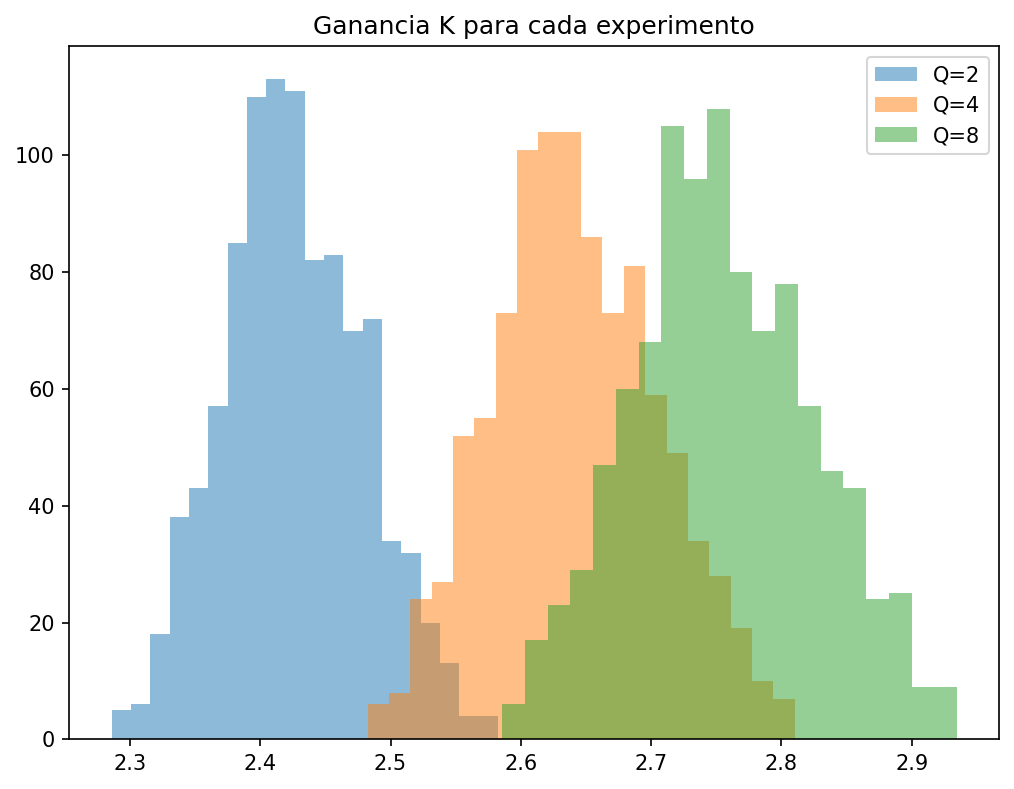

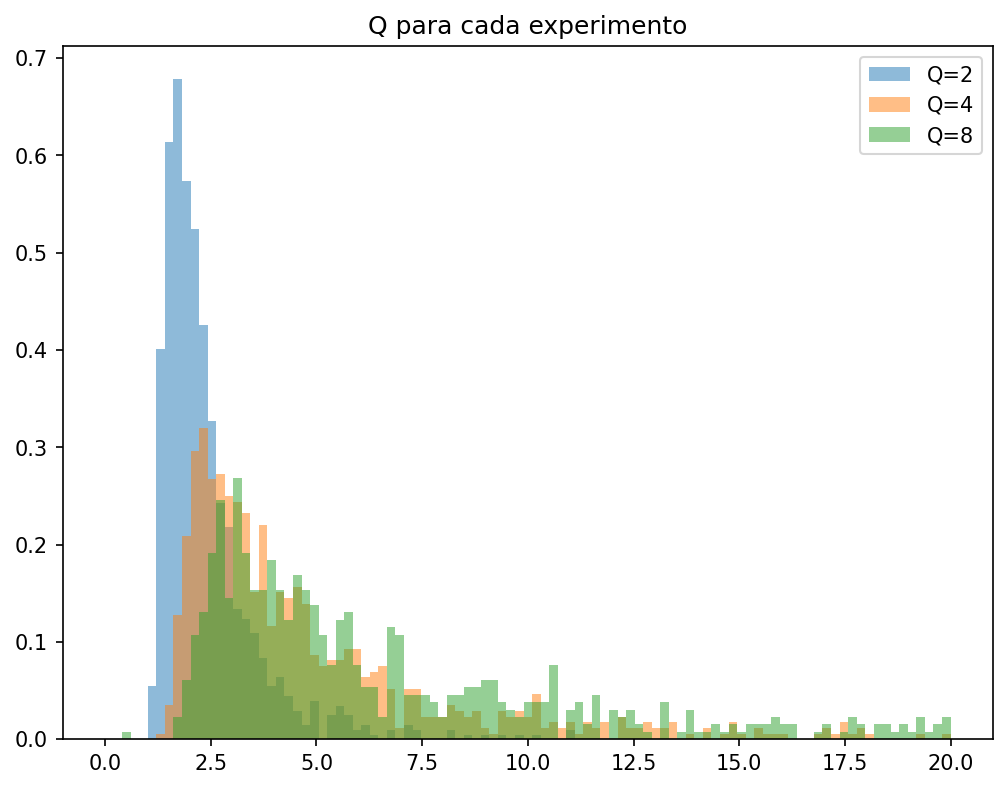

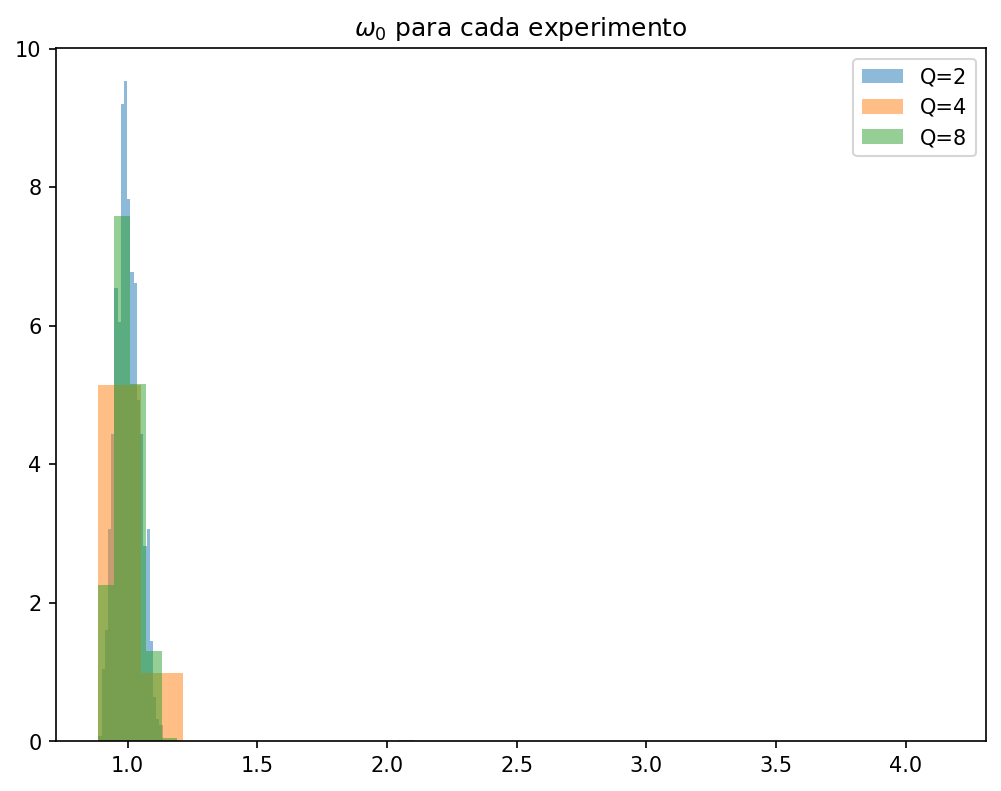

In [13]:


df = []


for ii in range(len(all_Qset)):
    # read the CSV file into a pandas dataframe
    df += [pd.read_csv('Sallen Key montecarlo Q{:d}.csv'.format(all_Qset[ii]))]

for ii in range(len(all_Qset)):
    plt.hist( df[ii]['k_meas'] , 20, alpha=0.5, label='Q={:d}'.format(all_Qset[ii]) )
plt.title('Ganancia K para cada experimento')
plt.legend()

plt.figure()
for ii in range(len(all_Qset)):
    # por como lo mido, tengo que dividir por el k. Porque mido T(wo) = k*Q
    plt.hist( df[ii]['q_meas']/df[ii]['k_meas'], np.linspace(0,20,100), density = True, alpha=0.5, label='Q={:d}'.format(all_Qset[ii]) )

plt.title('Q para cada experimento')
plt.legend()

plt.figure()
for ii in range(len(all_Qset)):
    #display( df[ii][np.bitwise_not( df[ii]['fo_meas'].isna())]['fo_meas'].describe())
    plt.hist( df[ii][np.bitwise_not( df[ii]['fo_meas'].isna())]['fo_meas'], 20, alpha=0.5, density = True, label='Q={:d}'.format(all_Qset[ii]) )

plt.title('$\omega_0$ para cada experimento')
plt.legend()

# enlace para volver al índice principal.
display(Markdown(r'[Volver al índice](#indice)'))

# display the plot
plt.show()


In [15]:
# enlace para presentar los resultados.
display(Markdown(r'<a id=''3.d''></a>'))

dfQ_ltspice = pd.concat([df[0]['q_meas']/df[0]['k_meas'], df[1]['q_meas']/df[1]['k_meas'], df[2]['q_meas']/df[2]['k_meas']], axis=1)
dfQ_ltspice.columns = all_Qset
    
print_subtitle('3.d) Descripción cuantitativa de los valores de Q')

display(Markdown(r'### Con LTspice'))

display(dfQ_ltspice.describe())

display(Markdown(r'### Con Python'))

display(dfQ.describe())


# enlace para volver al índice principal.
display(Markdown(r'[Volver al índice](#indice)'))


<a id=3.d></a>

#### 3.d) Descripción cuantitativa de los valores de Q

### Con LTspice

,2,4,8
count,1000.000000,915.000000,739.000000
mean,2.410744,11.107356,12.907302
std,1.217642,57.843077,30.317894
min,1.066502,1.399457,0.469502
25%,1.664355,2.682068,3.518321
50%,2.089641,3.872848,5.510944
75%,2.692272,6.444561,10.641510
max,11.107927,1436.969334,510.352210


### Con Python

,2,4,8
count,1000.000000,1000.000000,1000.000000
mean,1.642048,3.100022,6.906993
std,0.116534,0.526929,5.014198
min,1.387628,2.132387,2.982531
25%,1.560650,2.715017,4.739795
50%,1.632856,2.998034,5.878908
75%,1.718629,3.383179,7.593197
max,2.030782,5.267357,115.610804


[Volver al índice](#indice)

<a id='3.e'></a>

### 3.e) Conclusiones de la simulación circuital

Como se puede observar, los resultados son concordantes entre métodos de simulación circuital, numérica y simbólica. Para todas las simulaciones se observaron las limitaciones de la red Sallen-Key para alcanzar factores de selectividad $Q>3$. Otra característica distintiva de la simulación circuital, es que los valores extremos de $Q$ fueron aún más extremos que en la simulación numérica, afectando en definitiva a los **valores medios** que también cambiaron significativamente (3 a 11 para $Q=4$ y 7 a 13 para $Q=8$). Lamentablemente al no poder analizar los valores de los componentes asignados por LTspice, no podemos estar seguros de que las condiciones analizadas sean exactamente las mismas que realizamos en Python. Otra característica del análisis Montecarlo en LTspice, fue que algunas realizaciones fueron **inestables**. Esto se evidencia en la menor cantidad de mediciones automáticas que hubo para los $Q>3$ (1000, 915 y 739 para Q = 2, 4 y 8 respectivamente).

[Volver al índice](#indice)

<a id='4.0'></a>

### 4) Conclusiones generales de la simulación

En cuanto a la metodología presentada, resulta útil para analizar el comportamiento de una red y evaluar la dependencia respecto de los componentes que la integran. A partir de esta instancia dado que las simulaciones han sido concordantes, se podría pasar a una etapa de fabricación de un prototipo siempre que el Q a implementar no exceda el valor de 3.

[Volver al índice](#indice)